# Engineering Transparency into Your Multinomial Machine Learning Model with Python (Based on simulated data)

### Multinomial partial dependence, ICE, and Shapley explanations
In this notebook a gradient boosting machine (GBM) is trained to predict a multinomial target using a simulated dataset, Python, NumPy, Pandas, and XGBoost. First, the dataset is simulated. Then the multinomial model is trained. After the model is trained, partial dependence and individual conditional expectation (ICE) plots are used to analyze and verify the model's behavior. Finally an example of creating regulator mandated reason codes from high fidelity Shapley explanations for any model prediction is presented. This combination of partial dependence, ICE, and Shapley explanations is probably the most direct way to create an interpretable machine learning model today.

### Python imports

In [1]:
import numpy as np                   
import pandas as pd                 
import xgboost as xgb                
import shap
import string

import matplotlib.pyplot as plt
pd.options.display.max_columns = 999

%matplotlib inline

np.random.seed(12345)

In [2]:
class DataMakerAndGetter(object):

    """ This class makes randomly generated data sets. Generated data sets
    currently contain 15 columns of inputs - 3 of which are categorical - and
    one target variable. Randomly generated inputs are not correlated with
    one another or the target. Users may select to the number of rows in the
    generated data set, the type of target, and whether to save the generated
    data.

    :ivar seed: Random seed for enhanced reproducibility, default 12345.
    :ivar nrows: Number of rows of the  generated data set, default 100000.
    :ivar target: Can be 'numeric', 'binary', or multinomial, default 'binary'.
    :ivar save: Save or not save the file, default not save.
    :ivar noise: Adds noise to signal generating function, default False.

    """

    def __init__(self, seed=None, nrows=None, target=None, save=None,
                 one_function=None, noise=None):

        # init properties
        self.__ncols = 21
        self.__ncats = 0 #Leave out categoricals for XGBoosts sake...

        # set ivar defaults
        if seed is None:
            self.seed = 12345
        else:
            self.seed = seed

        if nrows is None:
            self.nrows = 100000
        else:
            self.nrows = nrows

        if target is None:
            self.target = 'binary'
        else:
            self.target = target

        if save is None:
            self.save = False
        else:
            self.save = save

        if one_function is None:
            self.one_function = False
        else:
            self.one_function = one_function

        if noise is None:
            self.noise = False
        else:
            self.noise = noise

    @property
    def ncols(self):

        """ Number of variables of the generated data set, fixed at 15. """

        return self.__ncols

    @property
    def ncats(self):

        """ Number of categorical variables in the generated data set,
        fixed at 3. """

        return self.__ncats

    def make_random(self):

        """ This function makes a random data set with user defined number of
        rows and type of target variable and can save the generated set as a
        CSV file. The default setting is 100000*15 variables, in which 3
        variables are categorical, plus one target column.

        :return: Returns a Pandas Dataframe with user defined number of rows
        and target variable type.

        """

        # set random seed
        np.random.seed(self.seed)

        # create numeric frame
        n_num_cols = self.ncols - self.ncats
        num_col_names = ['num' + str(i + 1) for i in range(0, n_num_cols)]
        num_cols = pd.DataFrame(np.random.randn(self.nrows, n_num_cols),
                                columns=num_col_names)

        # make categorical frame
        cat_col_names = map(lambda j: 'cat' + str(j + 1),
                            range(0, self.ncats))
        text_draw = [(letter * 8) for letter in string.ascii_uppercase[:7]]
        cat_cols = pd.DataFrame(np.random.choice(text_draw, (self.nrows,
                                                             self.ncats)),
                                columns=cat_col_names)

        # make target frame
        if self.target == 'binary':
            target_ = pd.DataFrame(np.random.choice([0, 1], size=self.nrows,
                                                    p=[0.5, 0.5]),
                                   columns=['target'])
        elif self.target == 'multinomial':
            target_ = pd.DataFrame(np.random.choice([0, 1, 2], size=self.nrows,
                                                    p=[.333333333334, .333333333334, .333333333334]),
                                   columns=['target'])
        else:
            target_ = pd.DataFrame(np.random.randint(100, size=self.nrows),
                                   columns=['target'])

        # column bind all frames together
        frame = pd.concat([num_cols, cat_cols, target_], axis=1)

        # add row_id
        frame['row_id'] = frame.index

        # conditionally save
        if self.save:
            frame.to_csv('random.csv', index=False)

        return frame

    def make_random_with_signal(self):

        """ This function transforms the dataset generated by make_random. The
        number of total variables are fixed at 15, with 3 of them being
        categorical. 9 of the numeric variable, num1 to num9, were used to transform
        the target. 3 of the numeric columns are totally random.
        The generated set can also be saved.

        :return: Returns a Pandas Dataframe with signal of user defined
        number of rows and type of target.

        """

        # local constants and settings
        cached_save = self.save
        self.save = False

        # make totally random frame
        frame = self.make_random()

        # function 1, on all rows
        frame.loc[::1, 'target'] = np.abs(frame.loc[::1, 'num8']) *\
            np.square(frame.loc[::1, 'num9']) + frame.loc[::1, 'num4'] *\
            frame.loc[::1, 'num1']

        frame.loc[::1, 'function'] = 1

        # function 2, on mod 2 rows
        if not self.one_function:
            frame.loc[::2, 'target'] = np.sin(frame.loc[::2, 'num6']) -\
                np.sqrt(np.abs(frame.loc[::2, 'num7'])) - frame.loc[::2, 'num2'] *\
                frame.loc[::2, 'num3']

            frame.loc[::2, 'function'] = 2
        
        if self.target != 'multinomial':
            cut = frame.loc[:, 'target'].mean()

        if self.noise:
            frame.loc[::5, 'target'] = 1
            frame.loc[::7, 'target'] = 0

        # set the cut off point for binary target
        if self.target == 'binary':
            frame.loc[frame['target'] >= cut, 'target'] = 1
            frame.loc[frame['target'] < cut, 'target'] = 0
        
        if self.target == 'multinomial':
            frame.loc[frame['target']  <= 0, 'target'] = 0
            frame.loc[(frame['target'] <= 1) & (frame['target'] > 0), 'target'] = 1
            #frame.loc[(frame['target'] <= 2) & (frame['target'] > 1), 'target'] = 2
            frame.loc[frame['target']  > 1, 'target'] = 2
            
        # conditionally save
        if cached_save:
            frame.to_csv('random_with_signal.csv', index=False)
            self.save = cached_save

        return frame

    @classmethod
    def get_percentile_dict(cls, y, id_, frame):

        """ Returns the percentiles of a column, yhat, as the indices based on
        another column id_.

        :param y: Column in which to find percentiles.
        :param id_: Id column that stores indices for percentiles of yhat.
        :param frame: Pandas Dataframe containing y and id_.

        :returns: Dictionary of percentile values and index column values.

        """

        # create a copy of frame and sort it by yhat
        sort_df = frame.as_data_frame()
        sort_df.sort_values(y, inplace=True)
        sort_df.reset_index(inplace=True)

        # find top and bottom percentiles
        percentiles_dict = {0: sort_df.loc[0, id_],
                            99: sort_df.loc[sort_df.shape[0] - 1, id_]}

        # find 10th-90th percentiles
        inc = sort_df.shape[0] // 10
        for i in range(1, 10):
            percentiles_dict[i * 10] = sort_df.loc[i * inc, id_]

        return percentiles_dict

### Known Signal Generating Function for Simulated Data
The outcome, `y (target)`, is generated based on the following formula:

$$y = x_1 * x_4 + |x_8| * (x_9)^2$$

This indicates that `y (target)` is highly correlated to `x1`, `x4`, `x8`, and `x9` which translate to `num1`, `num4`, `num8`, and `num9` in the generated dataset below.

# Data Generation

In [3]:
ds_ = DataMakerAndGetter(nrows=30000, target='multinomial', one_function=True, noise=True, seed=12345)
data = ds_.make_random_with_signal()
data.head()

,num1,num2,num3,num4,num5,num6,num7,num8,num9,num10,num11,num12,num13,num14,num15,num16,num17,num18,num19,num20,num21,target,row_id,function
0,-0.204708,0.478943,-0.519439,-0.555730,1.965781,1.393406,0.092908,0.281746,0.769023,1.246435,1.007189,-1.296221,0.274992,0.228913,1.352917,0.886429,-2.001637,-0.371843,1.669025,-0.438570,-0.539741,0.0,0,1.0
1,0.476985,3.248944,-1.021228,-0.577087,0.124121,0.302614,0.523772,0.000940,1.343810,-0.713544,-0.831154,-2.370232,-1.860761,-0.860757,0.560145,-1.265934,0.119827,-1.063512,0.332883,-2.359419,-0.199543,0.0,1,1.0
2,-1.541996,-0.970736,-1.307030,0.286350,0.377984,-0.753887,0.331286,1.349742,0.069877,0.246674,-0.011862,1.004812,1.327195,-0.919262,-1.549106,0.022185,0.758363,-0.660524,0.862580,-0.010032,0.050009,0.0,2,1.0
3,0.670216,0.852965,-0.955869,-0.023493,-2.304234,-0.652469,-1.218302,-1.332610,1.074623,0.723642,0.690002,1.001543,-0.503087,-0.622274,-0.921169,-0.726213,0.222896,0.051316,-1.157719,0.816707,0.433610,2.0,3,1.0
4,1.010737,1.824875,-0.997518,0.850591,-0.131578,0.912414,0.188211,2.169461,-0.114928,2.003697,0.029610,0.795253,0.118110,-0.748532,0.584970,0.152677,-1.565657,-0.562540,-0.032664,-0.929006,-0.482573,1.0,4,1.0


### Assign modeling roles

In [4]:
#Assign target and inputs for GBM
y = 'target'
X = [name for name in data.columns if name not in [y,'row_id','function']]
print('y =', y)
print('X =', X)

y = target
X = ['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8', 'num9', 'num10', 'num11', 'num12', 'num13', 'num14', 'num15', 'num16', 'num17', 'num18', 'num19', 'num20', 'num21']


### Display descriptive statistics

In [5]:
data.describe() #Display descriptive statistics for all columns

,num1,num2,num3,num4,num5,num6,num7,num8,num9,num10,num11,num12,num13,num14,num15,num16,num17,num18,num19,num20,num21,target,row_id,function
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.0
mean,0.012590,0.002605,-0.000579,0.007462,0.005243,-0.002555,0.000550,0.002338,0.001087,-0.001469,-0.003344,0.005400,0.012990,-0.009158,-0.004660,-0.003395,0.009174,0.004225,-0.002435,0.002337,-0.005233,0.877233,14999.500000,1.0
std,0.998170,0.999171,0.996087,0.998874,0.996718,1.002234,0.994695,0.988403,0.993752,0.999242,0.997853,1.003659,1.002058,0.999407,1.005237,1.002263,1.007168,1.002283,0.993666,0.995449,0.996649,0.728638,8660.398374,0.0
min,-4.263327,-3.892513,-4.150859,-3.793212,-3.916409,-3.628800,-3.776349,-4.501229,-3.558984,-4.092063,-4.106707,-4.179609,-4.071903,-4.301598,-3.905666,-3.926523,-3.924861,-3.957649,-5.057590,-4.148729,-4.250292,0.000000,0.000000,1.0
25%,-0.654347,-0.670167,-0.674723,-0.676910,-0.666627,-0.679165,-0.670021,-0.665613,-0.676052,-0.667745,-0.678147,-0.671923,-0.659966,-0.690996,-0.679288,-0.680801,-0.670903,-0.673475,-0.666851,-0.665201,-0.672575,0.000000,7499.750000,1.0
50%,0.006505,0.001560,-0.001632,0.008760,0.007613,-0.008698,0.006025,0.004705,0.001685,0.001303,-0.004356,0.004913,0.009361,-0.011090,-0.015657,-0.006959,0.003619,-0.003938,-0.006281,-0.000754,-0.004740,1.000000,14999.500000,1.0
75%,0.677308,0.674306,0.668459,0.680746,0.672513,0.673963,0.671605,0.664063,0.676483,0.667730,0.672814,0.691745,0.677649,0.659190,0.670662,0.669312,0.689647,0.674770,0.659730,0.670049,0.662423,1.000000,22499.250000,1.0
max,4.979780,4.100121,3.723884,3.867321,3.713553,4.569376,4.529198,3.990911,4.067701,4.390861,4.266457,4.481310,4.237124,3.927528,4.153813,4.034796,4.023149,3.636919,4.723747,3.958053,3.966642,2.000000,29999.000000,1.0


# Train multinomial XGBoost model

XGBoost is a very accurate, open source GBM library for regression and classification tasks. XGBoost can learn complex relationships between input variables and a target variable. XGBoost's early stopping functionality is also used to limit overfitting to the training data

XGBoost is available from: https://github.com/dmlc/xgboost and the implementation of XGBoost is described in detail here: http://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf.

After training, global Shapley variable importance is calculated and displayed. To enhance trust in the GBM model, variable importance values should typically conform to human domain knowledge and reasonable expectations.

### Split data into training and test sets for early stopping

The simulated dataset is split into training and test sets to monitor and prevent overtraining. Reproducibility is another important factor in creating trustworthy models, and randomly splitting datasets can introduce randomness in model predictions and other results. A random seed is used here to ensure the data split is reproducible.

In [6]:
np.random.seed(12345) #Set random seed for reproducibility
split_ratio = 0.7     #70%/30% train/test split

#Execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
test = data[~split]

#Summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 20946, columns = 24
Test data rows = 9054, columns = 24


### Train XGBoost GBM multinomial classifier
To train an XGBoost multinomial classifier, the training and test data must be converted from Pandas DataFrames into SVMLight format. The `DMatrix()` function in the XGBoost package is used to convert the data. 

Because gradient boosting methods typically resample training data, an additional random seed is also specified for XGBoost using the `seed` paramter to create reproducible predictions, error rates, and variable importance values. To avoid overfitting, the `early_stopping_rounds` parameter is used to stop the training process after the test multiclass logloss fails to decrease for 50 iterations.

In [7]:
dtrain = xgb.DMatrix(train[X], label=train[y])
dtest = xgb.DMatrix(test[X], label=test[y])

#Tuning parameters
params = {
    'objective': 'multi:softprob',              #Multinomial classification
    'booster': 'gbtree',                        #Base learner will be decision tree
    'eval_metric': 'mlogloss',                  #Stop training based on multinomial logloss
    'eta': 0.01,                                #Learning rate
    'subsample': 0.9,                           #Use 90% of rows in each decision tree
    'colsample_bytree': 0.9,                    #Use 90% of columns in each decision tree
    'max_depth': 6,                             #Allow decision trees to grow to depth of 6
    'seed': 12345,                              #Set random seed for reproducibility
    'num_class': 3,
    'silent': 1
}

#Watchlist is used for early stopping
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

#Train model
xgb_model = xgb.train(params,                   #Set tuning parameters from above                   
                      dtrain,                   #Training data
                      1000,                     #Maximum of 1000 iterations (trees)
                      evals=watchlist,          #Use watchlist for early stopping 
                      early_stopping_rounds=50, #Stop after 50 iterations (trees) without decrease in mlogloss
                      verbose_eval=False)       #Display iteration progress or not


### Global Shapley variable importance
By setting pred_contribs=True, XGBoost's predict() function will return Shapley values for each row and for each class of the test set. Instead of relying on traditional single-value variable importance measures, local Shapley values for each input will be plotted below to get a more holistic and consisent measurement for the global importance of each input variable.

In [8]:
#dtest is DMatrix
#shap_values is Numpy array
shap_values = xgb_model.predict(dtest, pred_contribs=True)

### Display Global Shapley variable importance summary

#### A good way to look at multinomial Shapley variable importance involves getting the mean absolute Shapley value across all classes.

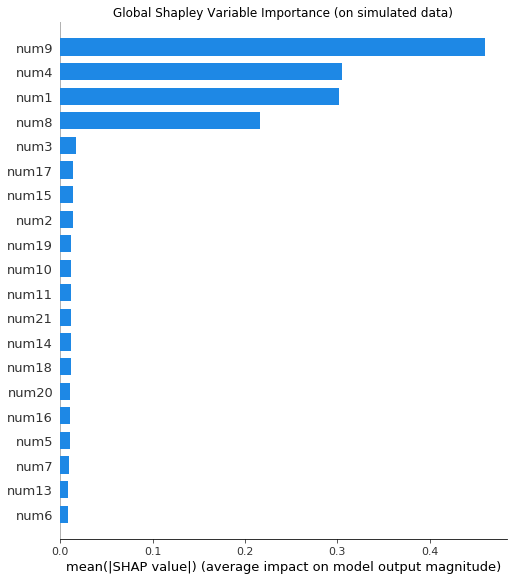

In [9]:
#Set all shapley values to their absolute value
shap_values_abs = np.absolute(shap_values[:,:,:-1])

#Plot mean absolute shapley across all classes for global shapley variable importance
plt.title("Global Shapley Variable Importance (on simulated data)")
shap.summary_plot(shap_values_abs.mean(axis=1), test[xgb_model.feature_names], plot_type="bar", show=False)
plt.savefig('./images/global_shapley_simulated.png',bbox_inches='tight')
plt.close()

#To show in notebook
plt.title("Global Shapley Variable Importance (on simulated data)")
shap.summary_plot(shap_values_abs.mean(axis=1), test[xgb_model.feature_names], plot_type="bar")

### Display Shapley variable importance summary per `target` class outcome

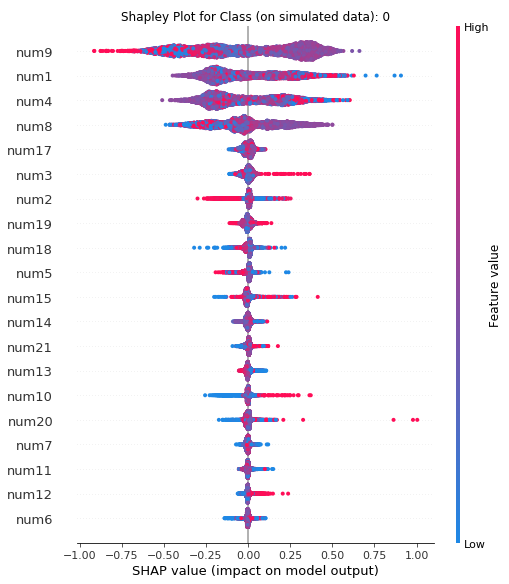

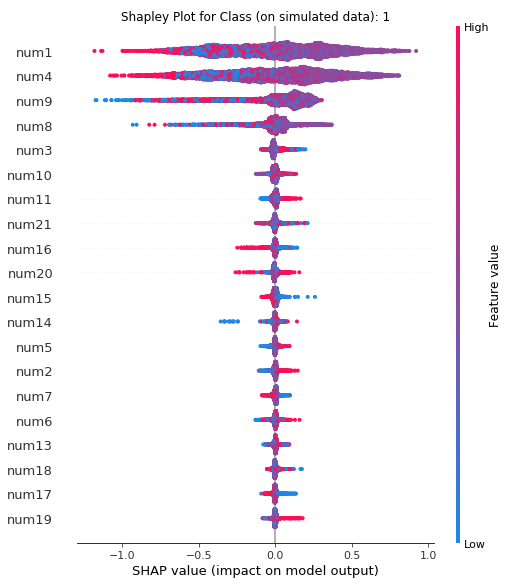

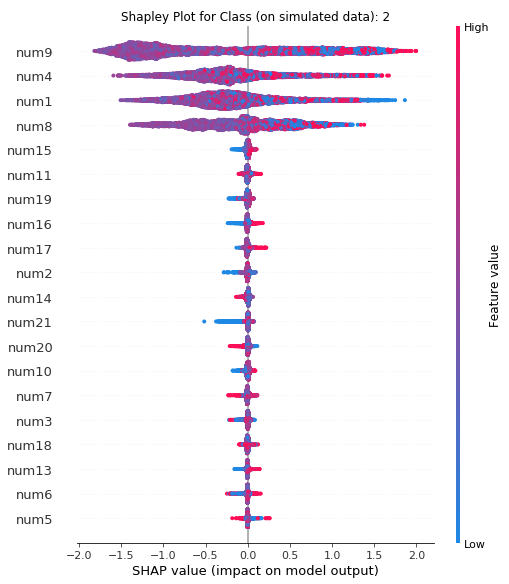

In [10]:
#Plot signed Shapley variable importance summary for a specific class (class 0, class 1, class2)
for i in range(0,3):
    plt.title("Shapley Plot for Class (on simulated data): " + str(i))
    shap.summary_plot(shap_values[:, i, :-1], test[xgb_model.feature_names], show=False)
    plt.savefig('./images/shapley_class_simulated' + str(i) + ".png", bbox_inches='tight')
    plt.close()
    #To show in notebook
    plt.title("Shapley Plot for Class (on simulated data): " + str(i))
    shap.summary_plot(shap_values[:, i, :-1], test[xgb_model.feature_names])

In [11]:
#Predict on test set
preds = xgb_model.predict(dtest)

In [12]:
#Display predictions as a Pandas frame
#Each column represents a class outcome for target: 0, 1, 2
pd.DataFrame(preds).head()

,0,1,2
0,0.185607,0.778113,0.036280
1,0.203291,0.786957,0.009752
2,0.647522,0.274129,0.078349
3,0.158393,0.143235,0.698373
4,0.242487,0.397277,0.360236


In [13]:
#Look at model accuracy
pred_prob = xgb_model.predict(dtest).reshape(test[y].shape[0], 3)
pred_label = np.argmax(pred_prob, axis=1)
error_rate = np.sum(pred_label != test[y]) / test[y].shape[0]
print('Test error using softprob = {}'.format(error_rate))

Test error using softprob = 0.2912524850894632


In [14]:
#For each line we need to select that column 
#where the probability is the highest
best_preds = np.asarray([np.argmax(line) for line in preds])
best_preds

array([1, 1, 0, ..., 0, 1, 2])

In [15]:
#Get actual values of target in test set
test_true = test["target"].values

In [16]:
#Look at confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_true, best_preds)
cnf_matrix

array([[1730,  919,  327],
       [ 503, 3206,  423],
       [  24,  441, 1481]])

In [17]:
#Look at precision and F1 with micro and macro averaging
from sklearn.metrics import precision_score, f1_score

print("Macro Precision: %s" % str(precision_score(test_true, best_preds, average='macro')))
print("Micro Precision: %s" % str(precision_score(test_true, best_preds, average='micro')))

print("Macro F1: %s" % str(f1_score(test_true, best_preds, average='macro')))
print("Micro F1: %s" % str(f1_score(test_true, best_preds, average='micro')))

Macro Precision: 0.7108261292437992
Micro Precision: 0.7087475149105368
Macro F1: 0.702496983620053
Micro F1: 0.7087475149105368


# Calculating partial dependence for a multinomial model
Partial dependence plots are used to view the global, average prediction behavior of a variable under the multinomial model. Multinomial partial dependence plots show the average prediction per class of the multinomial model as a function of specific values of an input variable of interest, indicating how the GBM predictions per class outcome change based on the values of the input variable of interest, while taking nonlinearity into consideration and averaging out the effects of all other input variables. Partial dependence plots enable increased transparency into the GBM's mechanisms and enable validation and debugging of the GBM by comparing a variable's average predictions per class across its domain to known standards and reasonable expectations. Partial dependence plots are described in greater detail in The Elements of Statistical Learning, section 10.13: https://web.stanford.edu/~hastie/ElemStatLearn/printings/ESLII_print12.pdf.

### Function for calculating multinomial partial dependence

In [18]:
def par_dep_multinomial(xs, frame, model, resolution=20, bins=None, num_classes=0):
    
    """ Creates Pandas DataFrame containing partial dependence for a 
        single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        model: XGBoost model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
        num_classes: Number of classes in outcome
    
    Returns:
        Pandas DataFrame containing partial dependence values per class.
        
    """
    
    #Turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    #Initialize empty Pandas DataFrame with correct column names
    class_name_columns = [0] * (num_classes + 1)
    class_name_columns[0] = xs
    for i in range(1, num_classes+1):
        class_name_columns[i] = 'partial_dependence_' + str(i-1)
    par_dep_frame = pd.DataFrame(columns=class_name_columns)
    
    #Cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    #Determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    #Calculate partial dependence  
    #by setting column of interest to constant 
    #and scoring the altered data and taking the mean of the predictions per class
    row_idx = 0 #Keep track of row index for proper assignment 
    #Per bin
    for j in bins:
        frame.loc[:, xs] = j
        dframe = xgb.DMatrix(frame)
        par_dep_i = pd.DataFrame(model.predict(dframe))
        #Per class
        for i in range(0, num_classes):
            par_dep_frame.loc[row_idx, xs] = j
            par_dep_j = par_dep_i[i].mean()
            par_dep_frame.loc[row_idx, 'partial_dependence_' + str(i)] = par_dep_j
        row_idx+=1 #Increment and go onto next row
        
    #Return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return par_dep_frame

### Calculate partial dependence for the most important input variable(s) in the GBM
`num9` is the most important variable according to global Shapley variable importance.

In [19]:
pdp_num9 = par_dep_multinomial(xs="num9", frame=test[X], model=xgb_model, resolution=20, bins=None, num_classes=3)
pdp_num9.head()

,num9,partial_dependence_0,partial_dependence_1,partial_dependence_2
0,-3.43941,0.230791,0.210895,0.558313
1,-3.08488,0.232398,0.21246,0.555142
2,-2.73034,0.229053,0.208548,0.562399
3,-2.37581,0.196514,0.225425,0.57806
4,-2.02128,0.198452,0.261847,0.539701


# Plotting multinomial partial dependence
Plotting the partial dependence per class is a good way of getting a global view of the multinomial model in question. 

**Note: If the number of outcome classes > 10, then we would only take the top 10 most common classes by default.**

In [20]:
def plot_multinomial_pdp(pdp_data, xs):
    fig, ax = plt.subplots()
    for i in range(0, 3):
        pdp_data.plot(x=xs,y="partial_dependence_"+str(i), ax=ax)
    plt.title("Multinomial Partial Dependency Plot (simulated data)")
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.savefig("./images/global_pdp_simulated.png", bbox_inches='tight')
    plt.show()
    plt.close()

### PDP for `num9` across all class outcomes for `target`

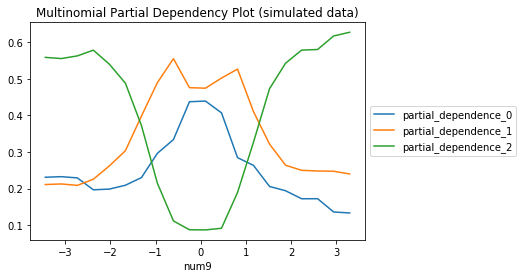

In [21]:
plot_multinomial_pdp(pdp_num9, "num9")

### Plotting partial dependence for a specific class outcome of interest

In [22]:
def plot_pdp_class_outcome(pdp_data, xs, class_category):
    fig, ax = plt.subplots()
    plt.title("Partial Dependency Plot for Outcome (on simulated data): " + str(class_category))
    pdp_data.plot(x=xs,y="partial_dependence_"+str(class_category), ax=ax)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.savefig("./images/pdp_class_simulated" + str(class_category) + ".png", bbox_inches='tight')
    plt.show()
    plt.close()

### PDP for `num9` and `target` outcome, `0`

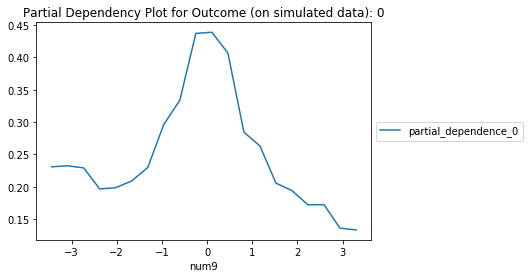

In [23]:
plot_pdp_class_outcome(pdp_num9, "num9", 0)

### PDP for `num9` and  all `target`  outcomes

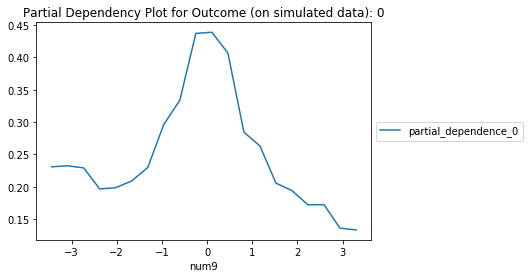

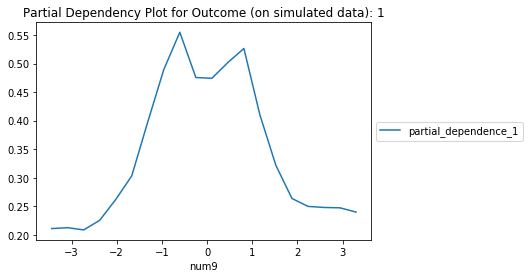

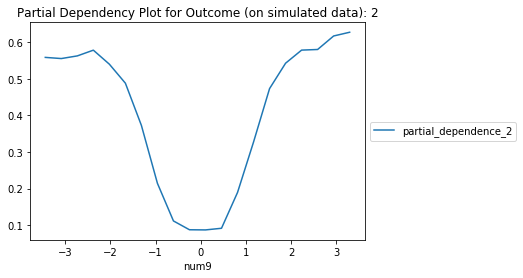

In [24]:
for i in range(0,3):
    plot_pdp_class_outcome(pdp_num9, "num9", i)

# Calculating Individual Conditional Expectation (ICE) for a multinomial model
Individual conditional expectation (ICE) plots, a newer and less well-known adaptation of partial dependence plots, can be used to create more localized explanations for a single observation of data using the same basic ideas as partial dependence plots. ICE is also a type of nonlinear sensitivity analysis in which the model predictions for a single observation are measured while a feature of interest is varied over its domain. ICE increases understanding and transparency by displaying the nonlinear behavior of the GBM. ICE also enhances trust, accountability, and fairness by enabling comparisons of nonlinear behavior to human domain knowledge and reasonable expectations. ICE, as a type of sensitivity analysis, can also engender trust when model behavior on simulated or extreme data points is acceptable. A detailed description of ICE is available in this arXiv preprint: https://arxiv.org/abs/1309.6392.

### Helper function for finding percentiles of predictions
ICE can be calculated for any row in the training or test data, but without intimate knowledge of a data source it can be difficult to know where to apply ICE. Calculating and analyzing ICE curves for every row of training and test data set can be overwhelming, even for the example credit card default dataset. One place to start with ICE is to calculate ICE curves at every decile of predicted probabilities in a dataset, giving an indication of local prediction behavior across the dataset. The function below finds and returns the row indices for the maximum, minimum, and deciles of one column in terms of another -- in this case, the model predictions for being in class 0 and the row identifier (row_id), respectively.

In [25]:
def get_percentile_dict(yhat, id_, frame):

    """ Returns the percentiles of a column, yhat, as the indices based on 
        another column id_.
    
    Args:
        yhat: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of yhat.
        frame: Pandas DataFrame containing yhat and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    #Create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat, inplace=True)
    sort_df.reset_index(inplace=True)
    
    #Find top and bottom percentiles
    percentiles_dict = {}
    percentiles_dict[0] = sort_df.loc[0, id_]
    percentiles_dict[99] = sort_df.loc[sort_df.shape[0]-1, id_]

    #Find 10th-90th percentiles
    inc = sort_df.shape[0]//10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc,  id_]

    return percentiles_dict

### Find some percentiles of yhat for a particular `target` outcome in the test data
The values for row_id that correspond to the maximum, minimum, and deciles of being in class 0 are displayed below. ICE will be calculated for the rows of the test dataset associated with these ID values.

In [26]:
def get_percentiles_for_class(dtest, class_category):
    #Merge GBM predictions onto test data
    yhat_test = pd.concat([test.reset_index(drop=True), pd.DataFrame(xgb_model.predict(dtest)[:,class_category])], 
                          axis=1)
    yhat_test = yhat_test.rename(columns={0:'p_class_' + str(class_category)})

    #Find percentiles of predictions
    percentile_dict = get_percentile_dict('p_class_' + str(class_category), 'row_id', yhat_test)

    #Display percentiles dictionary
    #ID values for rows
    #from lowest prediction 
    #to highest prediction
    return percentile_dict

In [27]:
percentile_dict = get_percentiles_for_class(dtest, 0)
percentile_dict

{0: 20754,
 99: 9232,
 10: 26827,
 20: 8910,
 30: 27888,
 40: 4781,
 50: 14513,
 60: 5728,
 70: 16192,
 80: 22018,
 90: 8582}

### Calculate ICE curve values for `num9` against a particular `target` outcome in the test data

In [28]:
def calc_ice_curves(pdp_data, xs, id_col, class_category, num_classes):
    """ Creates Pandas DataFrame containing partial dependence and ICE
    for a single variable
    
    Args:
        pdp_data: Data contain partial dependence for a specific variable
        xs: Variable for which to calculate partial dependence.
        id_col: Column name containing percentiles
        class_category: Class outcome of interest (an int ranging from 0-num_classes)
        num_classes: Number of classes in outcome
    
    Returns:
        Pandas DataFrame containing partial dependence and ICE values for a specific class outcome.
        
    """
    #Retreive bins from original partial dependence calculation
    bins = list(pdp_data[xs])
    pdp_ice_data = pdp_data[[xs, "partial_dependence_" + str(class_category)]]
    #Fr each percentile in percentile_dict
    #create a new column in the par_dep frame 
    #representing the ICE curve for that percentile
    #and the variables of interest
    for i in sorted(percentile_dict.keys()):

        col_name = 'Percentile_' + str(i)

        # ICE curves for target across percentiles at bin intervals
        pdp_ice_data[col_name] = par_dep_multinomial(xs, 
                                                  test[test[id_col] == int(percentile_dict[i])][X],  
                                                  xgb_model, 
                                                  bins=bins,
                                                  num_classes=num_classes)['partial_dependence_'+str(class_category)]
    return pdp_ice_data

### Calculate ICE curve values for `num9` against `target` outcome, `0` 

In [29]:
pdp_num9_class_zero = calc_ice_curves(pdp_num9, "num9", "row_id", 0, 3)
pdp_num9_class_zero.head()

,num9,partial_dependence_0,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-3.43941,0.230791,0.0469242,0.155394,0.201169,0.144133,0.194852,0.139832,0.231354,0.36878,0.436423,0.411535,0.504156
1,-3.08488,0.232398,0.0473844,0.155936,0.203358,0.145191,0.197347,0.140969,0.231827,0.370566,0.439837,0.410856,0.504798
2,-2.73034,0.229053,0.0468165,0.157586,0.194101,0.134971,0.18977,0.135614,0.230546,0.370274,0.428321,0.408586,0.48999
3,-2.37581,0.196514,0.0395511,0.118837,0.163605,0.102204,0.13539,0.112582,0.200117,0.306747,0.376401,0.417418,0.474108
4,-2.02128,0.198452,0.0402821,0.106936,0.167484,0.0955121,0.128814,0.112607,0.218809,0.289277,0.381804,0.455369,0.476923


# Plotting partial dependence and ICE for particular `target` outcome

In [30]:
def plot_par_dep_ICE(xs, par_dep_frame, class_index):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
        class_index: Class outcome of interest. XGBoost see's this as a value from 0-N where N is number of classes
    
    """
    
    #Initialize figure and axis
    fig, ax = plt.subplots()
    
    #Plot ICE curves
    par_dep_frame.drop('partial_dependence_' + str(class_index), axis=1).plot(x=xs, 
                                                                 colormap='gnuplot',
                                                                 ax=ax)

    #Overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs) 
                              + ' with class ' + str(class_index) + ' as an outcome',
                       x=xs, 
                       y='partial_dependence_' + str(class_index),
                       style='r-', 
                       linewidth=3, 
                       ax=ax)

    #Add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)
    
    plt.savefig("./images/pdp_ice_class_simulated" + str(class_index) + ".png", bbox_inches='tight')
    plt.show()
    plt.close()

### Plot PDP & ICE curves for `num9` against being in `target` outcome, `0` 

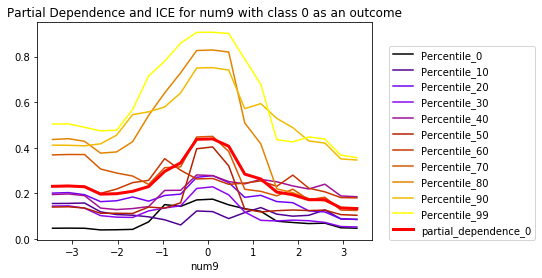

In [31]:
plot_par_dep_ICE('num9', pdp_num9_class_zero, 0)

### Plot PDP and ICE curves for `num9` against every class outcome in `target`

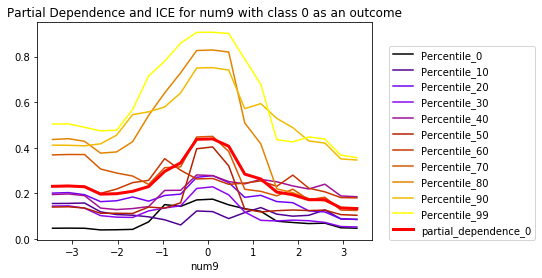

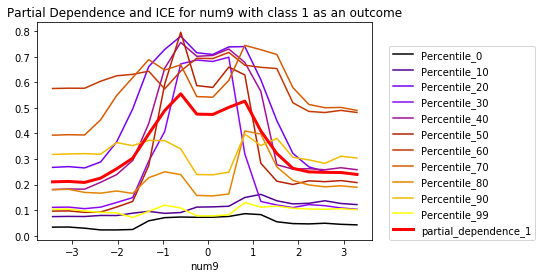

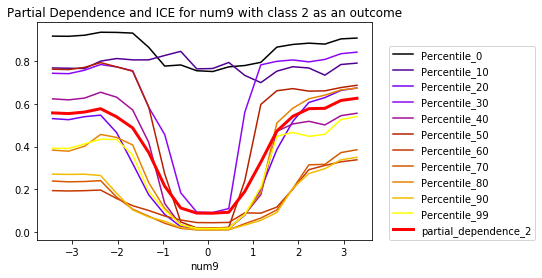

In [32]:
for i in range(0, 3):
    plot_par_dep_ICE('num9', calc_ice_curves(pdp_num9, "num9", "row_id", i, 3), i)

# Generate reason codes using the Shapley method
Now that global behavior of the GBM has been verified and compared against domain knowledge and reasonable expectations, a method called Shapley explanations will be used to calculate the local variable importance for any one prediction: http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions. Shapley explanations are the only possible consistent local variable importance values. (Here consistency means that if a variable is more important than another variable in a given prediction, the more important variable's Shapley value will not be smaller in magnitude than the less important variable's Shapley value.) Very crucially Shapley values also always sum to the actual prediction of the XGBoost model. When used in a model-specific context for decision tree models, Shapley values are likely the most accurate known local variable importance method available today. In this notebook, XGBoost itself is used to create Shapley values with the pred_contribs parameter to predict(), but the shap package is also available for other types of models: https://github.com/slundberg/shap.

The numeric Shapley values in each column are an estimate of how much each variable contributed to each prediction. Shapley contributions can indicate how a variable and its values were weighted in any given decision by the model. These values are crucially important for machine learning interpretability and are related to "local feature importance", "reason codes", or "turn-down codes." The latter phrases are borrowed from credit scoring. Credit lenders in the U.S. must provide reasons for automatically rejecting a credit application. Reason codes can be easily extracted from Shapley local variable contribution values by ranking the variables that played the largest role in any given decision.

To find the index corresponding to a particular row of interest later, the index of the test DataFrame is reset to begin at 0 and increase sequentially. Without resetting the index, the test DataFrame row indices still correspond to the original raw data from which the test set was sampled.

In [33]:
test.reset_index(drop=True, inplace=True)

### Function to plot Shapley values per class for a particular row at a certain decile

In [34]:
def plot_shapley_row(decile, row, class_index=None):
    if class_index is None:
        for i in range(0,3):
            s_df = pd.DataFrame(shap_values[row.index[0], i][:-1].reshape(21, 1), columns=['Reason Codes'], index=X)
            s_df.sort_values(by='Reason Codes', inplace=True)

            _ = s_df.plot(kind='bar', 
                              title='Reason Codes for Being in Class: ' + str(i) + ' (model predictions decile: ' + str(decile) + ')' + '\n', 
                              legend=False)
            plt.savefig("./images/shapley_simulated" + str(decile) + "_" + str(i) + ".png", bbox_inches='tight')
            plt.show()
            plt.close()
    else:
        s_df = pd.DataFrame(shap_values[row.index[0], class_index][:-1].reshape(21, 1), columns=['Reason Codes'], index=X)
        s_df.sort_values(by='Reason Codes', inplace=True)

        _ = s_df.plot(kind='bar', 
                  title='Reason Codes for Model Prediction: ' + str(class_index) + ' (model predictions decile: ' + str(decile) + ')' + '\n', 
                  legend=False)
        plt.savefig("./images/shapley_simulated" + str(decile) + "_" + str(class_index) + ".png", bbox_inches='tight')
        plt.show()
        plt.close()

### 10th decile of model predictions

In [35]:
decile = 10
row = test[test['row_id'] == percentile_dict[decile]]

### Display Local Shapley variable importance summary

#### A good way to look at multinomial Shapley variable importance involves getting the mean absolute Shapley value across all classes.

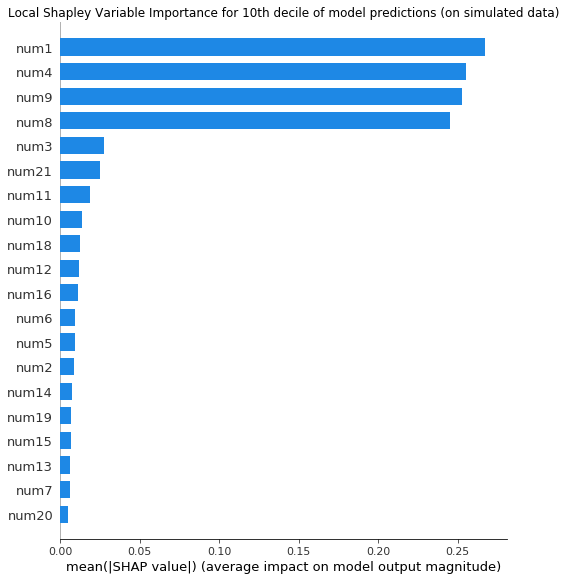

In [36]:
#Set all shapley values to their absolute value
shap_values_abs_row = np.absolute(shap_values[row.index[0],:,:-1])

#Plot mean absolute shapley across all classes for local shapley variable importance
plt.title("Local Shapley Variable Importance for 10th decile (on simulated data)")
shap.summary_plot(shap_values_abs_row, test[xgb_model.feature_names], plot_type="bar", show=False)
plt.savefig('./images/local_shapley_10decile_simulated.png',bbox_inches='tight')
plt.close()

#To show in notebook
#To show in notebook
plt.title("Local Shapley Variable Importance for 10th decile of model predictions (on simulated data)")
shap.summary_plot(shap_values_abs_row, test[xgb_model.feature_names], plot_type="bar", show=False)

### Local Shapley variable importance per `target` outcome

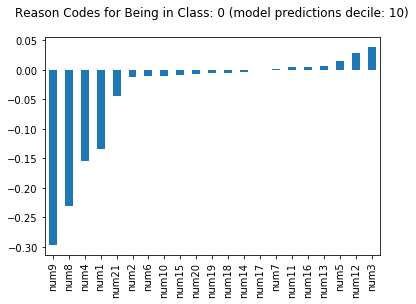

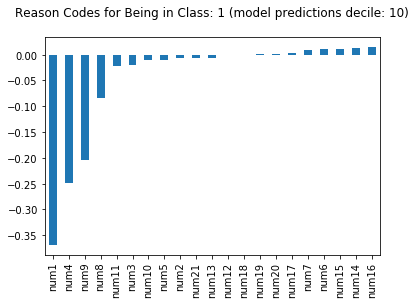

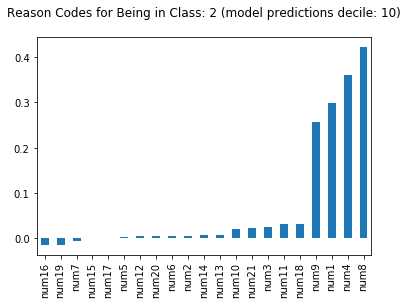

In [37]:
plot_shapley_row(decile, row)

### Function to get model predictions for minority class and majority class based on predicted probability

In [38]:
def get_pred(row, X):
    #Double check what the model actually predicted for this row
    row_pred = xgb_model.predict(xgb.DMatrix(row[X]))
    print("Predicted class probabilies: %s" % str(row_pred[0]))
    print("Smallest class probability based on model prediction: %s" % str(np.asarray([np.argmin(line) for line in row_pred])[0]))
    print("Highest class probability based on model prediction: %s" % str(np.asarray([np.argmax(line) for line in row_pred])[0]))

### What class does the model predict this row to be in?

In [39]:
get_pred(row, X)

Predicted class probabilies: [0.12886937 0.16148487 0.70964575]
Smallest class probability based on model prediction: 0
Highest class probability based on model prediction: 2


### Shapley reason codes for model prediction of this row

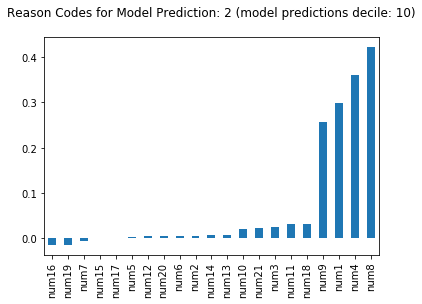

In [40]:
plot_shapley_row(decile, row, 2)

In [41]:
row #Helps understand reason codes

,num1,num2,num3,num4,num5,num6,num7,num8,num9,num10,num11,num12,num13,num14,num15,num16,num17,num18,num19,num20,num21,target,row_id,function
8123,-2.081108,0.934489,0.685352,-1.348157,-0.016189,0.018732,0.030974,-1.548881,1.419863,0.244457,1.756635,1.741932,-1.661983,0.986809,-0.550495,0.16889,-0.926334,-0.936557,-0.644494,-0.94762,-1.06561,2.0,26827,1.0


### 90th decile of model predictions

In [42]:
decile = 90
row = test[test['row_id'] == percentile_dict[decile]]

### Display Local Shapley variable importance summary 

#### A good way to look at multinomial Shapley variable importance involves getting the mean absolute Shapley value across all classes.

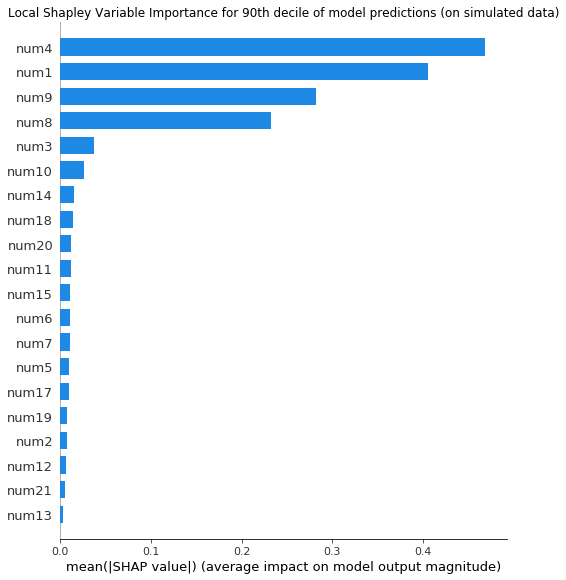

In [43]:
#Set all shapley values to their absolute value
shap_values_abs_row = np.absolute(shap_values[row.index[0],:,:-1])

#Plot mean absolute shapley across all classes for local shapley variable importance
plt.title("Local Shapley Variable Importance for 90th decile (on simulated data)")
shap.summary_plot(shap_values_abs_row, test[xgb_model.feature_names], plot_type="bar", show=False)
plt.savefig('./images/local_shapley_90decile_simulated.png',bbox_inches='tight')
plt.close()

#To show in notebook
plt.title("Local Shapley Variable Importance for 90th decile of model predictions (on simulated data)")
shap.summary_plot(shap_values_abs_row, test[xgb_model.feature_names], plot_type="bar", show=False)

### Local Shapley variable importance per `target` outcome

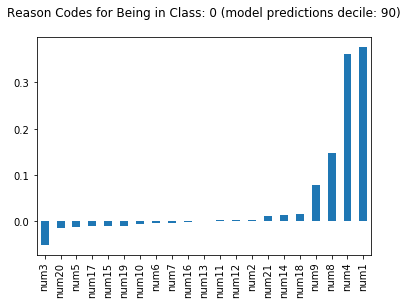

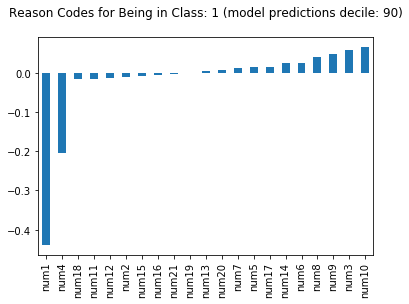

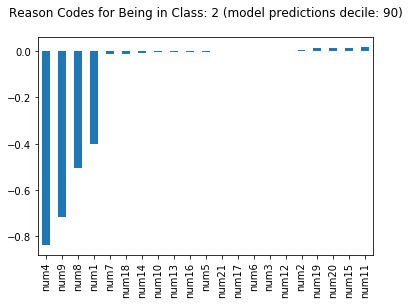

In [44]:
plot_shapley_row(decile, row)

### What class does the model predict?

In [45]:
get_pred(row, X)

Predicted class probabilies: [0.7125848  0.27318215 0.01423309]
Smallest class probability based on model prediction: 2
Highest class probability based on model prediction: 0


### Shapley Reason codes for model prediction

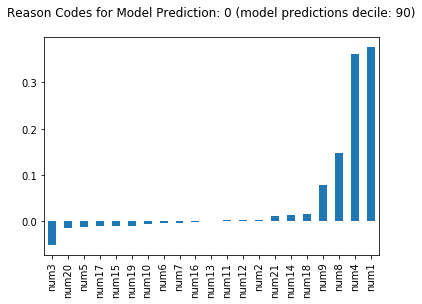

In [46]:
plot_shapley_row(decile, row, 0)

In [47]:
row #Helps understand reason codes

,num1,num2,num3,num4,num5,num6,num7,num8,num9,num10,num11,num12,num13,num14,num15,num16,num17,num18,num19,num20,num21,target,row_id,function
2614,-1.504279,1.048802,0.884749,0.933747,0.934636,-0.255936,0.339327,-0.311423,0.636043,1.686534,0.334316,1.513762,-0.273847,0.861008,0.415773,-0.548111,-1.010806,-0.069742,0.135688,-1.733576,-0.221152,0.0,8582,1.0


### Write out predictions, predicted class, and original columns to disk

In [48]:
preds = pd.DataFrame(xgb_model.predict(dtest))
preds.columns = ['prob_target_class' + str(col) for col in preds.columns]
test_with_preds = pd.concat([test.reset_index(drop=True), preds], axis=1)
test_with_preds = test_with_preds.drop(['row_id', 'function'], axis=1)
test_with_preds["pred_target"] = test_with_preds[preds.columns].idxmax(axis=1).str.split('_').str.get(2)
test_with_preds.head()

,num1,num2,num3,num4,num5,num6,num7,num8,num9,num10,num11,num12,num13,num14,num15,num16,num17,num18,num19,num20,num21,target,prob_target_class0,prob_target_class1,prob_target_class2,pred_target
0,-0.204708,0.478943,-0.519439,-0.555730,1.965781,1.393406,0.092908,0.281746,0.769023,1.246435,1.007189,-1.296221,0.274992,0.228913,1.352917,0.886429,-2.001637,-0.371843,1.669025,-0.438570,-0.539741,0.0,0.185607,0.778113,0.036280,class1
1,0.107657,-0.606545,-0.417064,-0.017007,-1.224145,-1.800840,1.634736,0.989008,0.457940,0.555154,1.306720,-0.440554,-0.301350,0.498791,-0.823991,1.320566,0.507965,-0.653438,0.186980,-0.391725,-0.272293,1.0,0.203291,0.786957,0.009752,class1
2,1.920784,0.746433,2.224660,-0.679400,0.727369,-0.868731,-1.213851,-0.470631,-0.919242,-0.838827,0.435155,-0.557805,-0.567455,-0.372642,-0.926557,1.755108,1.209810,1.270025,-0.974378,-0.634709,-0.395701,0.0,0.647522,0.274129,0.078349,class0
3,1.457300,0.609512,-0.493779,1.239980,-0.135722,1.430042,-0.846852,0.603282,1.263572,-0.255491,-0.445688,0.468367,-0.961604,-1.824505,0.625428,1.022872,1.107425,0.090937,-0.350109,0.217957,-0.894813,1.0,0.158393,0.143235,0.698373,class2
4,-1.741494,-1.052256,1.436603,-0.576207,-2.420294,-1.062330,0.237372,0.000957,0.065253,-1.367524,-0.030280,0.940489,-0.642437,1.040179,-1.082922,0.429214,-0.236224,0.641818,-0.331661,1.394072,-1.076742,2.0,0.242487,0.397277,0.360236,class1


In [50]:
#Write train, test, and test with preds to csv
test_with_preds.to_csv("./output/simulated_mult_preds.csv", index=False)
train.to_csv("./data/simulated_train.csv", index=False)
test.to_csv("./data/simulated_test.csv", index=False)